In [2]:
from sdof_pinn import bbnn, sdof_pinn, normalise, ParamClipper
from sdof_oscillators import sdof_solution, add_noise, generate_excitation

import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.rcParams.update({
    'text.usetex' : True,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral'
})

%load_ext autoreload
%autoreload 2

In [3]:
result_data_fm = torch.load('results/sdof_cubic_fm.pth')

Text(0.95, 0.3, '$D^*=\\emptyset$')

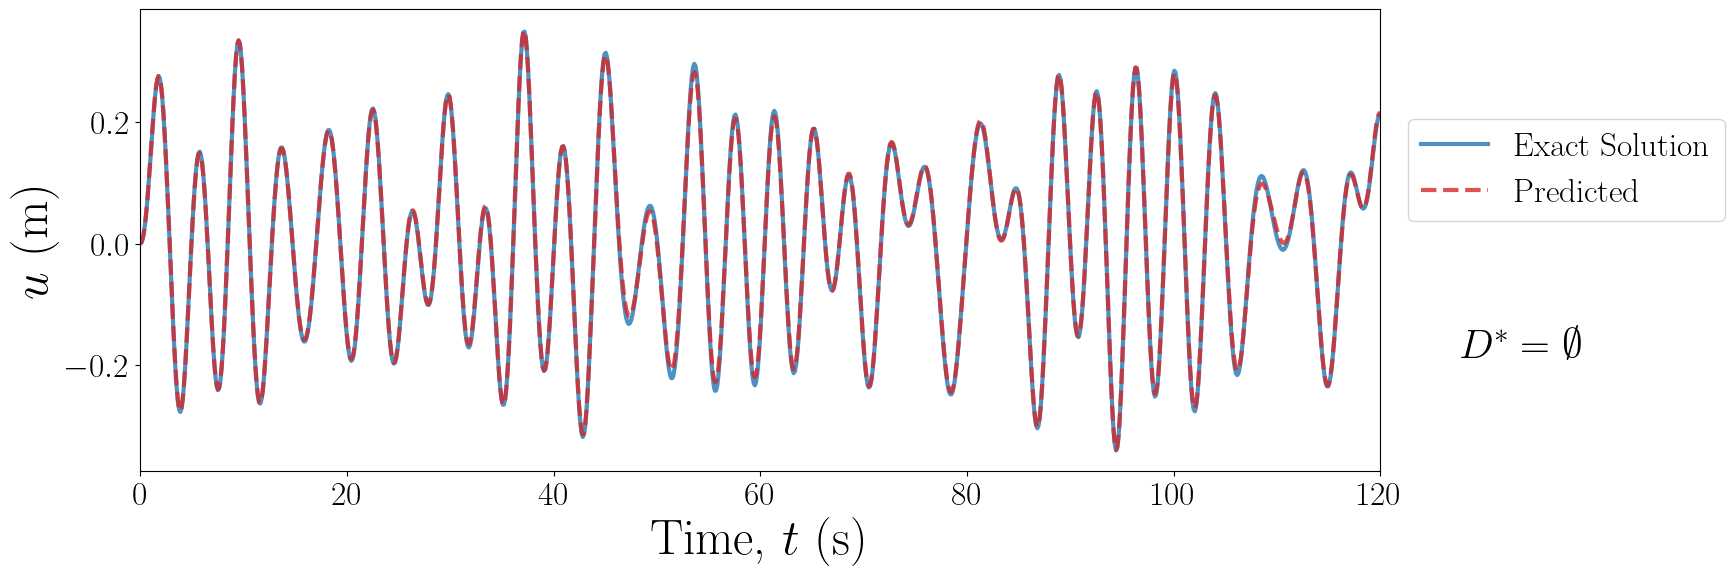

In [4]:
x_gt = [None] * 2
x_pred = [None] * 2
fig, ax = plt.subplots(figsize=(16,6))

gt_config = result_data_fm["gt_config"]
pinn_config = result_data_fm["osa_config"]
model_dict = result_data_fm["model"]
loss_hist = result_data_fm["loss"]
ground_truth = result_data_fm["ground_truth"]
data = result_data_fm["data"]
prediction = result_data_fm["prediction"]
alphas = result_data_fm["alphas"]

pi_model = sdof_pinn(
    N_INPUT = 1,
    N_OUTPUT = 1,
    N_HIDDEN = 32,
    N_LAYERS = 4
    )
pi_model.configure(pinn_config)
pi_model.load_state_dict(model_dict)

# ground truths
t = ground_truth["t_hat"] * alphas["t"]
x_gt = ground_truth["x_hat"] * alphas["x"]
f_gt = pi_model.force * alphas["F"]

# training data
t_data = data["t_hat"] * alphas["t"]
x_data = data["x_hat"] * alphas["x"]
x_pred = pi_model(t/alphas["t"]).detach() * alphas["x"]

ax.plot(t, x_gt, color="tab:blue", linewidth=3, alpha=0.8, label="Exact Solution")
ax.plot(t, x_pred, color="tab:red", linestyle='--', linewidth=3, alpha=0.8, label="Predicted")
# axs[i].scatter(t_data, x_data, marker="o", s=36, color="tab:gray", label="Training Data")
ax.set_ylabel(r"$u$ (m)", fontsize=36)
ax.set_xlabel(r"Time, $t$ (s)", fontsize=36)
ax.set_xlim((0, 120))
ax.tick_params(axis='both', which='major', labelsize=24)
ax.legend(fontsize=24, loc='upper center', bbox_to_anchor=(1.15,0.8))
ax.text(0.95, 0.3, '$D^*=\\emptyset$', fontsize=30, transform=plt.gcf().transFigure)

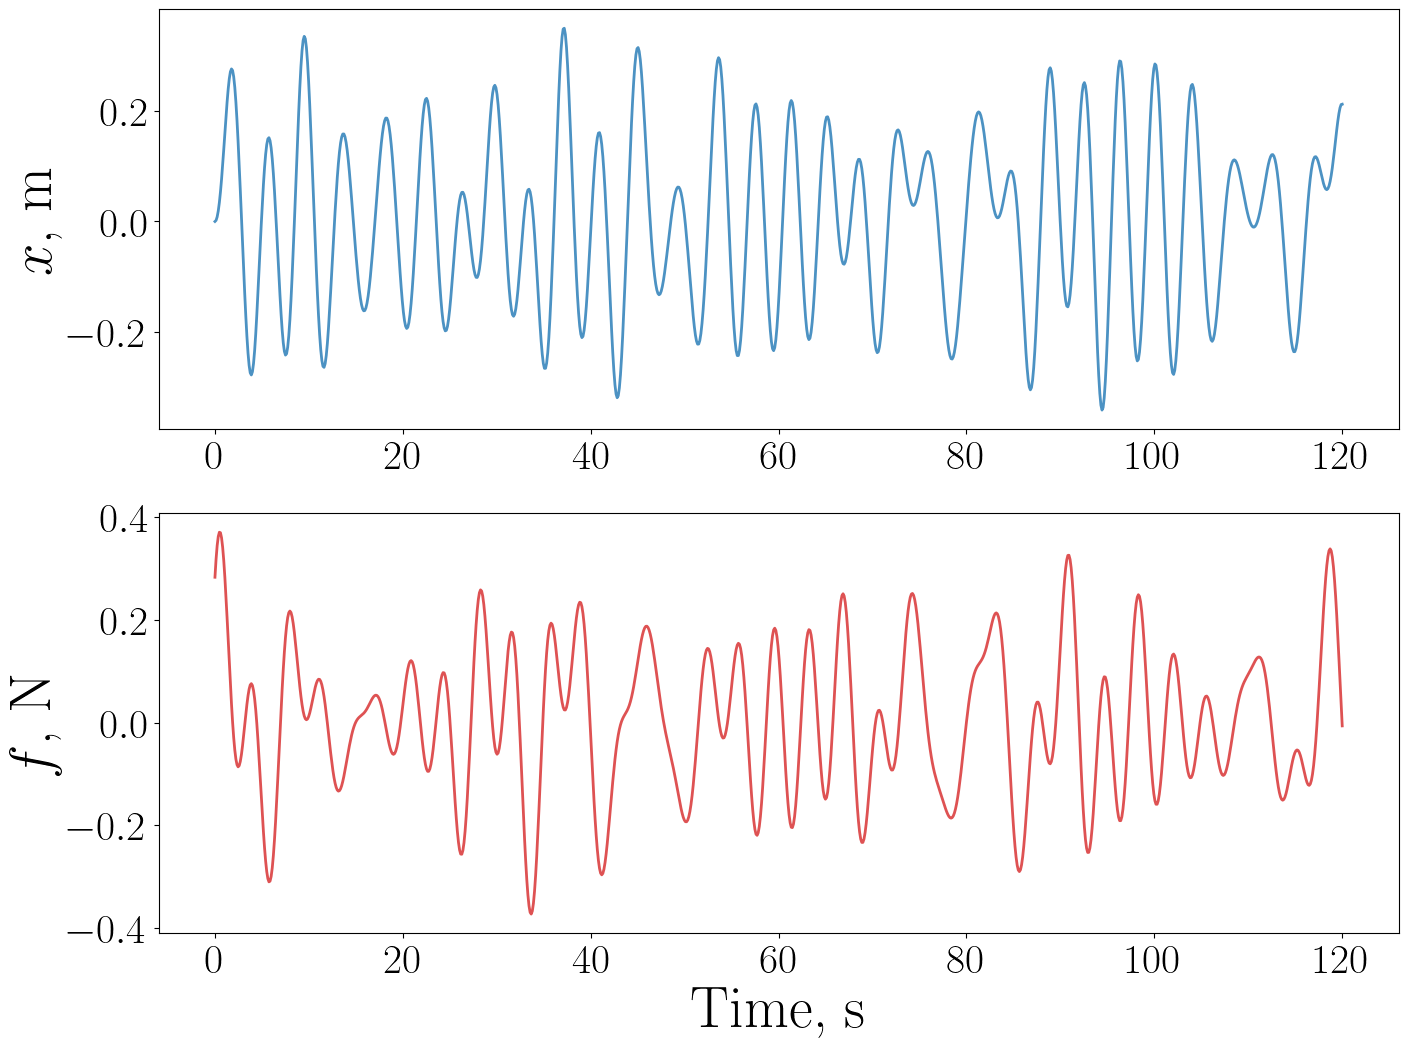

In [5]:
fig, axs = plt.subplots(2,1,figsize=(16,12))
axs[0].plot(t, x_gt, color="tab:blue", linewidth=2, alpha=0.8, label="Displacement")
axs[0].set_ylabel("$x$, m", fontsize=42)
# axs[0].set_xlabel("Time, s", fontsize=36)
axs[0].tick_params(axis='both', which='major', labelsize=30)
# axs[0].legend(fontsize=20, loc='lower center')

axs[1].plot(t, f_gt.detach(), color="tab:red", linewidth=2, alpha=0.8, label="Forcing Signal")
axs[1].set_ylabel("$f$, N", fontsize=42)
axs[1].set_xlabel("Time, s", fontsize=42)
axs[1].tick_params(axis='both', which='major', labelsize=30)
# axs[1].legend(fontsize=20, loc='lower center')

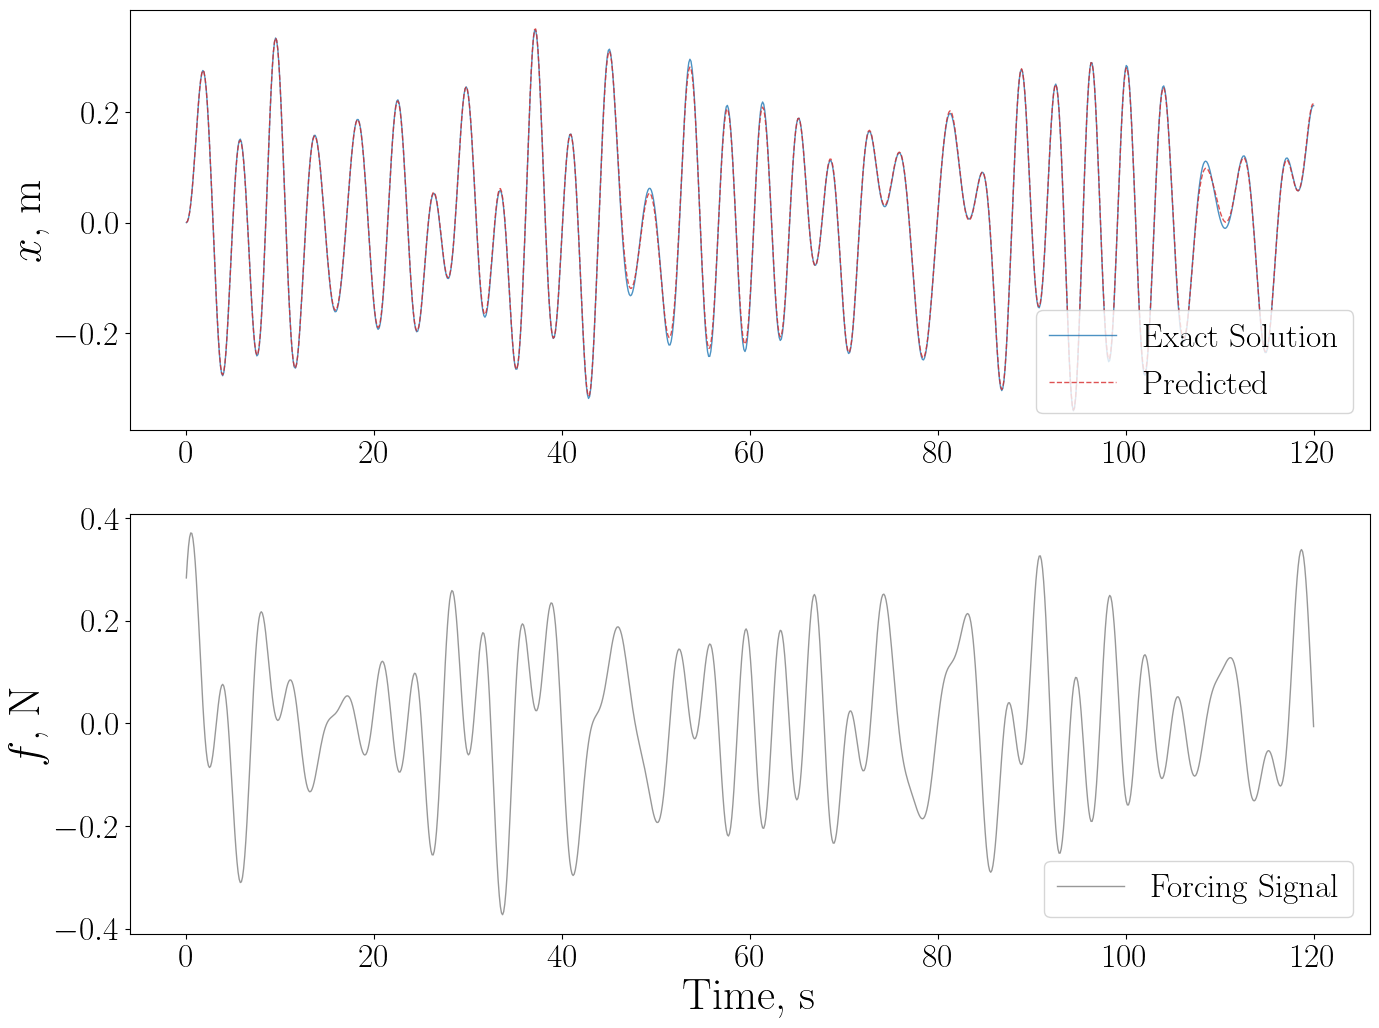

In [6]:
# equation discovery results

fig, axs = plt.subplots(2,1,figsize=(16,12))
axs[0].plot(t, x_gt, color="tab:blue", linewidth=1, alpha=0.8, label="Exact Solution")
axs[0].plot(t, x_pred, color="tab:red", linestyle='--', linewidth=1, alpha=0.8, label="Predicted")
axs[0].set_ylabel("$x$, m", fontsize=32)
# axs[0].set_xlabel("Time, s", fontsize=36)
axs[0].tick_params(axis='both', which='major', labelsize=24)
axs[0].legend(fontsize=24, loc='lower right')

axs[1].plot(t, f_gt.detach(), color="tab:gray", linewidth=1, alpha=0.8, label="Forcing Signal")
axs[1].set_ylabel("$f$, N", fontsize=32)
axs[1].set_xlabel("Time, s", fontsize=32)
axs[1].tick_params(axis='both', which='major', labelsize=24)
axs[1].legend(fontsize=24, loc='lower right')

In [7]:
nt = 1024
t = np.linspace(0,120,nt)

F0 = 0.1  # N

# excitation = {
#     "type" : "sinusoid",
#     "F0" : F0,
#     "w" : 1.6  # rad/s
# }

excitation = {
    "type" : "rand_phase_ms",
    "F0" : F0,
    "freqs" :   np.array([0.7, 0.85, 1.6, 1.8]),
    "Sx" :      np.array([1.0, 1.0, 1.0, 1.0])
}

# excitation = {
#     "type" : "white_gaussian",
#     "F0" : F0,
#     "offset" :   0.0
# }

# excitation = {
#     "type" : "sine_sweep",
#     "F0" : F0,
#     "w" :   np.array([0.4, 2.8]),
#     "scale" :  "linear"
# }

F = generate_excitation(t, **excitation)
excitation["F"] = F.reshape(-1)

### Generate training and ground truth
m = 10.0
c = 1.0
k = 15.0
k3 = 100.0
excitation["F_tild"] = excitation["F"]/m

wn = np.sqrt(k/m)
zeta = c/(2*m*wn)
wd = wn*np.sqrt(1-zeta**2)

k_tild = k/m
c_tild = c/m
k3_tild = k3/m

gt_config = {
    "nonlinearity" : "cubic",
    # "m_norm" : False,
    # "params" : {
    #     "m" : m,
    #     "k" : k,
    #     "c" : c,
    #     "k3" : k3
    # },
    "m_norm" : True,
    "params" : {
        "k_tild" : k_tild,
        "c_tild" : c_tild,
        "k3_tild" : k3_tild
    },
    "init_conds" : {
        "x0" : 0.0,
        "v0" : 0.0
    },
    "forcing" : excitation
}

x, v = sdof_solution(t, **gt_config)
x_noisy = add_noise(x.view(-1,1), 0.02)
t = torch.tensor(t).view(-1,1).to(torch.float32)

# slice out a number of points from the start of the signal
sub_ind = np.arange(0, int(nt/1), 4)

t_data = t[sub_ind]
x_data = x_noisy[sub_ind]

fig, axs= plt.subplots(2,1)
axs[0].plot(t, x_noisy, color="gray", label="Noisy data")
axs[0].plot(t, x, label="Exact solution")
axs[0].scatter(t_data, x_data, color="tab:orange", label="Training data")
axs[0].legend()

axs[1].plot(t, excitation["F_tild"], color="red", label="Forcing")
axs[1].legend()

TypeError: generate_excitation() got an unexpected keyword argument 'type'